In [1]:
machine = "derecho" #"laptop_Z30" or "derecho"

if machine == "laptop_Z30":
    path_to_base_param_files_root = '/home/adamhb/gdrive/postdoc/parameters'
    path_to_ensemble_param_files_root = '/home/adamhb/gdrive/postdoc/parameters/ensemble_1280_041724'
    path_to_ca_fates = '/home/adamhb/gdrive/postdoc/california-fates'
    path_to_esm_tools = '/home/adamhb/gdrive/FATES/Earth-System-Model-Tools'
    
if machine == "derecho":
    path_to_base_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25'
    path_to_ensemble_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/'
    path_to_ca_fates = '/glade/u/home/adamhb/california-fates/'
    path_to_esm_tools = '/glade/u/home/adamhb/Earth-System-Model-Tools/'

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix
import numpy as np
#import tensorflow
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import os
from scipy.stats import qmc
pd.set_option('display.max_rows', 500) 
import shutil
import netCDF4 as nc4
import sys
sys.path.append("/glade/u/home/adamhb/california-fates/ensemble_tools/")
sys.path.append(path_to_esm_tools)
import esm_tools
import modp as mp
from scipy.io import netcdf as nc
import re

2024-09-03 16:49:42.524220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 16:49:42.571131: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 16:49:42.573273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 16:49:43.409808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Specify paths and load emulator

In [2]:
# Load parameter ranges
param_ranges_full = pd.read_csv(os.path.join(path_to_ca_fates,'parameter_ranges/param_range_archive/param_ranges_050124.csv'))

# The parameter file used for parameter values that don't vary in the ensemble 
base_param_file_name = 'ca_ahb_5pfts_041624.nc'

# New param file name prefix for the parameter files that do vary
file_name_prefix = 'ca_5pfts_100523'

# Instances per case
inst_per_case = 128

# Cases
n_cases = 20

target_ensemble_size = inst_per_case * n_cases

# Prefix for subdirectories where param files for the ensemble are kept
param_files_subdir_prefix = f'ml_supported_ensemble_{target_ensemble_size}_050224'

# How large should each lhs sample be in the generator
batch_size = target_ensemble_size
starting_seed = 19

path_DNN_NFailed_PFTs = os.path.join(path_to_ca_fates,'ml_emulators/DNN_NFailed_050224_v2.h5')
DNN_NFailed_PFTs = keras.models.load_model(path_DNN_NFailed_PFTs)
#DNN_NFailed_PFTs = tf.keras.models.load_model(path_DNN_NFailed_PFTs)
path_to_ensemble_data = '/glade/work/adamhb/processed_output/CZ2_equilibrium_041924_and_042324_XX.csv'

2024-09-03 16:49:57.235148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Check DNN models

In [3]:
#path_DNN_NFailed_PFTs = os.path.join(path_to_ca_fates,'ml_emulators/DNN_NFailed_050224_v2.h5')
path_DNN_NFailed_PFTs_safety = os.path.join(path_to_ca_fates,'ml_emulators/DNN_NFailed_050224_v2_safety_090324.h5')
DNN_NFailed_PFTs_safety = keras.models.load_model(path_DNN_NFailed_PFTs_safety)

In [4]:
DNN_NFailed_PFTs_safety 

In [5]:
DNN_NFailed_PFTs

In [6]:
# Get the weights of both models
weights_model1 = DNN_NFailed_PFTs.get_weights()
weights_model2 = DNN_NFailed_PFTs_safety.get_weights()

In [16]:
weights_model1[1]

array([-0.11061223, -0.02029976, -0.08666242, -0.12775111,  0.00968531,
       -0.02679835,  0.00529409, -0.02017334, -0.03897494, -0.10177479,
       -0.04447145, -0.05741761, -0.05119246,  0.02432603, -0.06113547,
       -0.03455589, -0.0579376 , -0.01930605, -0.11189925, -0.03961933,
       -0.10150902, -0.02549509, -0.08333644, -0.16468485, -0.04728054,
       -0.06578464,  0.00830015, -0.04631326, -0.0150412 , -0.04864179,
       -0.15530959, -0.02400835, -0.0531337 ,  0.02829574, -0.00124064,
       -0.02239525, -0.02316466, -0.00457663,  0.0030259 ,  0.02394329,
       -0.14355211, -0.0551059 , -0.08194575, -0.04871113, -0.05445457,
       -0.02174707, -0.11209171, -0.0906097 , -0.04328284, -0.08421073,
       -0.022024  , -0.10482734,  0.04892705, -0.04775207, -0.11232956,
       -0.07370903, -0.10534902, -0.04673783, -0.02950015, -0.09718163,
       -0.12516299, -0.11004289, -0.11445973,  0.04908418, -0.07354227,
       -0.03026463, -0.07489718,  0.0710741 , -0.04080461, -0.11

In [17]:
weights_model2[1]

array([-0.14964452, -0.08791615, -0.09420598, -0.13486715, -0.195609  ,
       -0.06127151, -0.14338483, -0.09139641, -0.10991365, -0.14961888,
       -0.06173363, -0.17739016, -0.12962186, -0.20026806, -0.11052709,
       -0.107485  , -0.12761723, -0.11774354, -0.12074115, -0.12244402,
       -0.127415  , -0.09453408, -0.22040439, -0.19052792, -0.03640621,
       -0.0905396 , -0.08572555, -0.08255496, -0.01447071, -0.14623839,
       -0.21127675, -0.08209895, -0.15659681,  0.00177904, -0.19927406,
       -0.096369  , -0.11590685, -0.08429983, -0.04384252,  0.07253131,
       -0.24109094, -0.10859931, -0.0708028 , -0.11430287, -0.06758809,
       -0.18302377, -0.2309797 , -0.1256754 , -0.14567618, -0.05850684,
       -0.20881857, -0.14046247, -0.18405457, -0.00123839, -0.18992485,
       -0.20750512, -0.16011798, -0.18719369, -0.18810499, -0.12692511,
       -0.14683095, -0.13516438, -0.19879022, -0.05031055, -0.1435025 ,
       -0.2192934 , -0.09330314, -0.10081229, -0.21705581, -0.16

In [12]:
weights_model2[0][0,:]

array([-0.10132692,  0.06871355,  0.02420656, -0.06587879, -0.02077255,
        0.13136944,  0.04368519, -0.04856068,  0.1123883 ,  0.1681869 ,
       -0.01894324, -0.04467728, -0.05350537, -0.09750614, -0.13993338,
       -0.06758236, -0.06946594, -0.11629251, -0.00287961, -0.16054891,
       -0.02025933, -0.12078473,  0.07547171, -0.054306  ,  0.00118154,
        0.04451109,  0.0082708 , -0.01219495, -0.11915407,  0.08981577,
       -0.02978093, -0.00283035,  0.06133944, -0.02855127, -0.16503935,
        0.10828822,  0.12822169, -0.10091759,  0.0912905 ,  0.05278141,
        0.03631198, -0.0519996 ,  0.15130901, -0.05767677,  0.06226451,
       -0.06857625, -0.11154885,  0.11857247, -0.02722597, -0.1256025 ,
        0.1145075 ,  0.07500373, -0.17907992, -0.00884408, -0.0292221 ,
        0.01815606, -0.0713377 ,  0.14213994,  0.00737328, -0.07647021,
        0.1514096 ,  0.14087646,  0.12283061, -0.17557718, -0.00773613,
       -0.06083052, -0.06378185,  0.08289511, -0.03872313,  0.18

## Functions

In [18]:
# pfts = np.array(param_ranges['pft'])
# indices = np.maximum(pfts - 1,0)
# param_index_names = [params[i] + "_" + str(indices[i]) for i in list(range(len(params)))]

def get_param_pft_name(v,p,pft_index = False):
    if pft_index == True:
        p = max(0,p-1)
    return v + "_" + str(p)

def contains_angle_brackets(s):
    return '<' in s or '>' in s

def get_param_value_from_ineq(ref_pft_value,min_val,max_val,pft_ineq):
    '''returns the parameter value for the pft that depends on a reference pft value'''
    
    if contains_angle_brackets(pft_ineq):
        if ">" in pft_ineq:
            min_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
        if "<" in pft_ineq:
            max_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
    else:
        new_value = ref_pft_value
    
    return new_value

def find_duplicates(lst):
    count = {}
    duplicates = []

    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1

    for key, value in count.items():
        if value > 1:
            duplicates.append(key)

    return duplicates

def remove_duplicates(lst):
    no_duplicates = []
    [no_duplicates.append(x) for x in lst if x not in no_duplicates]
    return no_duplicates

def add_pft_nums(input_string,numbers):
    return [input_string + "_{}".format(i) for i in numbers]

def add_param_names_for_writing_to_netcdf():
    
    '''It needs to have all the variable names and indices required to write a netcdf file with the parameter values
    The variable names and indices required to write the netcdf file are contained in the column headers, but there are some exceptions:

    * fates_leaf_slamax_{1:5} equals fates_leaf_sla25top{1:5}
    * fates_allom_d2ca_coefficient_min_{1:5} equals fates_allom_d2ca_coefficient_max_{1:5}
    * fates_frag_maxdecomp_{2,3,5} are calcuated as specific fractions of fates_frag_maxdecomp_1
    * fates_mort_hf_sm_threshold_{1:5} are the same as fates_mort_hf_sm_threshold_0
    * fates_recruit_inter_patch_disp_frac_{1:5} are same as fates_recruit_inter_patch_disp_frac_0
    '''
     
    # These are added so that when we write to netcdf files we can just use the column headers as a guide for
    # param name and index
    
    # add fates_leaf_slamax_{1:5} 
    slamax = add_pft_nums("fates_leaf_slamax",[1,2,3,4,5])
    
    # add fates_allom_d2ca_coefficient_min_{1:5}
    allom_d2ca = add_pft_nums("fates_allom_d2ca_coefficient_min",[1,2,3,4,5])
    
    # add fates_frag_maxdecomp_{2,3,5}
    maxdecomp = add_pft_nums("fates_frag_maxdecomp",[2,3,5])
    
    # add fates_mort_hf_sm_threshold_{1:5}
    hf = add_pft_nums("fates_mort_hf_sm_threshold",[1,2,3,4,5])
    
    # add fates_recruit_inter_patch_disp_frac_{1:5}
    disp = add_pft_nums("fates_recruit_inter_patch_disp_frac",[1,2,3,4,5])
    
    return slamax + allom_d2ca + maxdecomp + hf + disp

def generate_lhs_df(batch_size, seed, param_ranges):

    sampler = qmc.LatinHypercube(d=n_params, seed=seed)
    sample = sampler.random(n=batch_size)

    # scale to parameter ranges
    l_bounds = param_ranges['value_min']
    u_bounds = param_ranges['value_max']

    scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

    print("ensemble dimensions:",scaled_sample.shape)

    # Create a dataframe of the LHS ensemble
    col_names = [get_param_pft_name(v,p) for v,p in zip(param_names,pfts)]
    lhs_df = pd.DataFrame(data=scaled_sample,columns=col_names)
    
    return lhs_df


def add_inequality_cols(lhs_df,param_ranges_inequalities):

    # Create column names of the inequalities parameters
    
    col_names_inequalities = [get_param_pft_name(v,p) for v,p in zip(param_ranges_inequalities["param"],param_ranges_inequalities['pft'])]

    # Add columns names for special cases
    col_names_inequalities = col_names_inequalities + add_param_names_for_writing_to_netcdf()

    col_names_inequalities = remove_duplicates(col_names_inequalities)
    
    def remove_element(lst, element_to_remove):
        return [item for item in lst if item != element_to_remove]
 
    col_names_inequalities = remove_element(col_names_inequalities, "fates_frag_maxdecomp_0")
    
    inequalities_df = pd.DataFrame(np.zeros((lhs_df.shape[0],len(col_names_inequalities))),columns=col_names_inequalities)

    # Concatenate the dfs
    df = pd.concat([lhs_df,inequalities_df], axis = 1)

    return df

def get_ref_pft_num(ineq):  
    for p in pft_names:
        if p in ineq:
            return pft_names.index(p) + 1
        
def generate_parameter_values_for_inequalities(param_ranges_inequalities,df):
    
    print("Adding pft inequalities...")
    
    for ensemble_member_row in df.index:
    
        for i in param_ranges_inequalities.index:

            # input data from the inequalities df
            d = param_ranges_inequalities.loc[i]

            # Make sla max the same as slatop
            if d['param'] == "fates_leaf_slamax":
                for i in range(1,6):
                    pft_to_assign_value_to = i
                    reference_col = "fates_leaf_slatop_" + str(pft_to_assign_value_to)
                    target_col = "fates_leaf_slamax_" + str(pft_to_assign_value_to)
                    reference_val = df.loc[ensemble_member_row,reference_col]
                    target_val = reference_val
                    df.at[ensemble_member_row,target_col] = target_val
                    if i == 1:
                        df.at[ensemble_member_row,"fates_leaf_slamax_0"] = target_val

            # Make d2camin the same as d2ca max
            if d['param'] == "fates_allom_d2ca_coefficient_min":
                for i in range(1,6):
                    pft_to_assign_value_to = i
                    reference_col = "fates_allom_d2ca_coefficient_max_" + str(pft_to_assign_value_to)
                    target_col = "fates_allom_d2ca_coefficient_min_" + str(pft_to_assign_value_to)
                    reference_val = df.loc[ensemble_member_row,reference_col]
                    target_val = reference_val
                    df.at[ensemble_member_row,target_col] = target_val
                    if i == 1:
                        df.at[ensemble_member_row,"fates_allom_d2ca_coefficient_min_0"] = target_val

            # Calculate fates_frag_maxdecomp
            if d['param'] == "fates_frag_maxdecomp":
                col_name_suffix = d['organ']
                reference_col = "fates_frag_maxdecomp_0"
                target_col = "fates_frag_maxdecomp_" + str(int(col_name_suffix))
                

                reference_val = df.loc[ensemble_member_row,reference_col]

                target_val = reference_val * d['value_max']

                df.at[ensemble_member_row,target_col] = target_val

            # Set fates_mort_hf_sm_threshold the same for all pfts
            for i in range(1,6):
                pft_to_assign_value_to = i
                reference_col = "fates_mort_hf_sm_threshold_0"
                target_col = "fates_mort_hf_sm_threshold_" + str(int(pft_to_assign_value_to))
                
                reference_val = df.loc[ensemble_member_row,reference_col]

                target_val = reference_val
                
                df.at[ensemble_member_row,target_col] = target_val

            # Set fates_mort_hf_sm_threshold the same for all pfts
            for i in range(1,6):
                pft_to_assign_value_to = i
                reference_col = "fates_recruit_inter_patch_disp_frac_0"
                target_col = "fates_recruit_inter_patch_disp_frac_" + str(int(pft_to_assign_value_to))
                reference_val = df.loc[ensemble_member_row,reference_col]
                target_val = reference_val
                df.at[ensemble_member_row,target_col] = target_val
            
            # Set the inequalities
            if get_ref_pft_num(d['pft_ineq']) is not None:
                pft_to_assign_value_to = d["pft"]
                reference_pft_num = get_ref_pft_num(d['pft_ineq'])
                reference_col = d['param'] + "_" + str(int(reference_pft_num))
                reference_val = df.loc[ensemble_member_row,reference_col]
                target_col = d['param'] + "_" + str(int(pft_to_assign_value_to))
                target_val = get_param_value_from_ineq(reference_val,min_val = d['value_min'],
                                                       max_val = d['value_max'],pft_ineq = d['pft_ineq'])
                df.at[ensemble_member_row,target_col] = target_val
                
    print("Finished adding pft inequalities!")
            

def check_na_and_zeros(df):
    # Check for NA values in each column
    na_count = df.isna().sum()
    print("NA counts in each column:")
    print(na_count)

    # Check for zeros in each column
    zero_count = (df == 0).sum()
    print("\nZero counts in each column:")
    print(zero_count)
    
    

def get_substring_before_underscore(s):
    match = re.search(r'^(.*?)_(?=\d)', s)
    return match.group(1) if match else None

def get_last_number(s):
    matches = re.findall(r'\d+', s)
    return int(matches[-1]) if matches else None

def assign_var_to_nc(file,var_name,value,index):
    
    '''
    assigns a value to a netcdf for a particular pft and organ
    
    file = full path to netcdf
    var_name = fates parameter name
    value = parameter value to add to file
    '''
    
    # open nc file
    ncfile = nc.netcdf_file(file, 'a')
    
    # define param of interest
    var = ncfile.variables[var_name]
    
    # get number of dimensions
    ndim = len(var.dimensions)
    
    if var_name == "fates_stoich_nitr":
        organ_index = 0
        var[organ_index,index] = value
    
    elif "fates_leafage_class" in var.dimensions:
        var[:,index] = value
   
    elif ndim == 0:
        
        var[...] = value
    
    else:
        var[index] = value

## Check that saved model is working

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Columns: 137 entries, Unnamed: 0.1 to param_file_path
dtypes: float64(120), int64(14), object(3)
memory usage: 3.2+ MB


['Unnamed: 0', 'inst_tag', 'AGCD', 'BA_conifer', 'BA_trees', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_shrub', 'BA_oak', 'TreeStemD', 'TreeStemD_40', 'TreeStemD_60', 'TreeStemD_80', 'TreeStemD_100', 'ResproutD_oak', 'ResproutD_shrub', 'ShannonE', 'NPP', 'FailedPFTs', 'Pct_shrub_cover_canopy', 'Pct_shrub_cover', 'Combustible_fuel', 'Pct_conifer_cover_canopy', 'Pct_pine_cover_canopy', 'Pct_cedar_cover_canopy', 'Pct_fir_cover_canopy', 'Pct_oak_cover_canopy', 'Burned_area', 'Pct_high_severity_1700', 'Pct_high_severity_3500', 'case_number', 'case_num_inst_id', 'fates_recruit_seed_alloc_mature_1', 'fates_recruit_seed_alloc_mature_2', 'fates_recruit_seed_alloc_mature_3', 'fates_recruit_seed_alloc_mature_4', 'fates_recruit_seed_alloc_mature_5', 'fates_recruit_seed_dbh_repro_threshold_1', 'fates_recruit_seed

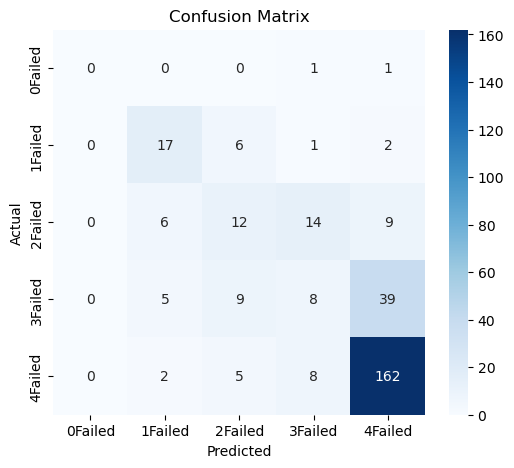

              precision    recall  f1-score   support

     0Failed       0.00      0.00      0.00         2
     1Failed       0.57      0.65      0.61        26
     2Failed       0.38      0.29      0.33        41
     3Failed       0.25      0.13      0.17        61
     4Failed       0.76      0.92      0.83       177

    accuracy                           0.65       307
   macro avg       0.39      0.40      0.39       307
weighted avg       0.59      0.65      0.61       307



/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [21]:
raw_df = pd.read_csv(path_to_ensemble_data)
raw_df.info()
print("\n")

# Drop first column
raw_df.drop(columns=raw_df.columns[0], axis=1, inplace=True)
print(list(raw_df.columns))

df = raw_df.copy()
df.fillna(0, inplace=True)
df = df.loc[df['FailedPFTs'] != 5]

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['FailedPFTs']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_y_failedPFTs = test_set["FailedPFTs"].copy()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This is for if I need to define a custom data transformation function
from sklearn.base import BaseEstimator, TransformerMixin

# Data transformation pipeline
transformation_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # Scale the data by substracting mean and dividing by sigma
    ])

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

# Apply to test data
X_test = transformation_pipeline.fit_transform(test_X)


from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


loss, accuracy = DNN_NFailed_PFTs.evaluate(X_test, test_y_failedPFTs)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


probabilities = DNN_NFailed_PFTs.predict(X_test)
y_pred_a = np.argmax(probabilities, axis=1)
print(y_pred)

probabilities = DNN_NFailed_PFTs_safety.predict(X_test)
y_pred_b = np.argmax(probabilities, axis=1)
print(y_pred)

target_names = [str(i) + "Failed" for i in range(5)]

# Compute the confusion matrix
cm = confusion_matrix(test_y_failedPFTs, y_pred)

# Display the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Optionally, display the classification report for more detailed metrics
print(classification_report(test_y_failedPFTs, y_pred, target_names= target_names))

In [23]:
pd.DataFrame({'a':y_pred_a, 'b':y_pred_b})

,a,b
0,4,4
1,3,3
2,3,3
3,1,4
4,4,4
5,4,4
6,3,4
7,3,4
8,1,1
9,1,1


## Load parameter ranges

In [32]:
pft_names = ['pine','cedar','fir','shrub','oak']
param_ranges_full = param_ranges_full[['pft_ineq','param', 'value_min', 'value_max', 'pft', 'organ']]

# Define params that we are going to sample from the LHS
param_ranges = param_ranges_full.loc[param_ranges_full['pft_ineq'] == 'FALSE']

# Define params that we are going to alter using pft-inequalities
param_ranges_inequalities = param_ranges_full.loc[param_ranges_full['pft_ineq'] != 'FALSE']
param_ranges_inequalities = param_ranges_inequalities.dropna(how="all")

# Make sure min and max are floats
convert_dict = {'value_min': float,
                'value_max': float}

param_ranges = param_ranges.astype(convert_dict)

# number of parameters
n_params = len(param_ranges)
print("Number of params:",n_params)

# number of PFTs - '0' is global so subtract one
n_pfts = max(len(pd.unique(param_ranges['pft'])) - 1, 1)
print("Number of pfts:", n_pfts)

param_names = list(param_ranges.param)
print("Param names:",param_names)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)
param_ranges.info()

Number of params: 56
Number of pfts: 5
Param names: ['fates_recruit_seed_alloc_mature', 'fates_recruit_seed_alloc_mature', 'fates_recruit_seed_alloc_mature', 'fates_recruit_seed_dbh_repro_threshold', 'fates_recruit_seed_dbh_repro_threshold', 'fates_fire_bark_scaler', 'fates_fire_alpha_SH', 'fates_fire_alpha_SH', 'fates_fire_alpha_SH', 'fates_fire_drying_ratio', 'fates_fire_nignitions', 'fates_mort_bmort', 'fates_mort_bmort', 'fates_leaf_slatop', 'fates_leaf_slatop', 'fates_leaf_slatop', 'fates_leaf_vcmax25top', 'fates_leaf_vcmax25top', 'fates_leaf_vcmax25top', 'fates_fire_frac_resprout', 'fates_fire_frac_resprout', 'fates_frag_seed_decay_rate', 'fates_frag_seed_decay_rate', 'fates_frag_seed_decay_rate', 'fates_recruit_seed_germination_rate', 'fates_recruit_seed_germination_rate', 'fates_recruit_seed_germination_rate', 'fates_disturbance_germ', 'fates_turnover_branch', 'fates_turnover_branch', 'fates_turnover_leaf', 'fates_turnover_leaf', 'fates_turnover_leaf', 'fates_nonhydro_smpsc', '

## Create LHS without the ML model

In [33]:
# # Create df of potential parameterizations
# lhs_df = generate_lhs_df(batch_size, starting_seed, param_ranges)
# df = add_inequality_cols(lhs_df,param_ranges_inequalities)
# generate_parameter_values_for_inequalities(param_ranges_inequalities,df)

## Generate promising ensemble members with the ML model

In [34]:
df_promising = pd.DataFrame()

while len(df_promising) < target_ensemble_size:
    
    if len(df_promising) == 0:
        seed = starting_seed
    else:
        seed = seed + 1
    
    print("LHS seed:",seed)
    
    # Create df of potentail paramterizations
    lhs_df = generate_lhs_df(batch_size, seed, param_ranges)
    df = add_inequality_cols(lhs_df,param_ranges_inequalities)
    generate_parameter_values_for_inequalities(param_ranges_inequalities,df)

    # Check which ones will work
    X = transformation_pipeline.fit_transform(df[X_cols])
    probabilities = DNN_NFailed_PFTs.predict(X)
    y_pred = np.argmax(probabilities, axis=1)
    y_pred_0 = [i == 1 for i in y_pred]
    df_promising = pd.concat([df_promising,df[y_pred_0]])
    
    print(len(df_promising), "promising ensemble members so far...")
    df_promising_reset = df_promising.reset_index()

LHS seed: 19
ensemble dimensions: (2560, 56)
Adding pft inequalities...
Finished adding pft inequalities!
80/80 [==============================] - 0s 833us/step
301 promising ensemble members so far...
LHS seed: 20
ensemble dimensions: (2560, 56)
Adding pft inequalities...
Finished adding pft inequalities!
80/80 [==============================] - 0s 855us/step
572 promising ensemble members so far...
LHS seed: 21
ensemble dimensions: (2560, 56)
Adding pft inequalities...
Finished adding pft inequalities!
80/80 [==============================] - 0s 853us/step
831 promising ensemble members so far...
LHS seed: 22
ensemble dimensions: (2560, 56)
Adding pft inequalities...
Finished adding pft inequalities!
80/80 [==============================] - 0s 910us/step
1115 promising ensemble members so far...
LHS seed: 23
ensemble dimensions: (2560, 56)
Adding pft inequalities...
Finished adding pft inequalities!
80/80 [==============================] - 0s 1ms/step
1422 promising ensemble members 

## Make subdirectories for parameter files

In [35]:
param_file_subdirs = []
for subdir_i in range(n_cases):
    subdir_tag = str(subdir_i+1).rjust(2, '0')
    param_file_subdirs.append(param_files_subdir_prefix +"_" + subdir_tag)
print(param_file_subdirs)

for i in range(len(param_file_subdirs)):
    os.makedirs(os.path.join(path_to_ensemble_param_files_root,param_file_subdirs[i]),exist_ok=True)

['ml_supported_ensemble_2560_050224_01', 'ml_supported_ensemble_2560_050224_02', 'ml_supported_ensemble_2560_050224_03', 'ml_supported_ensemble_2560_050224_04', 'ml_supported_ensemble_2560_050224_05', 'ml_supported_ensemble_2560_050224_06', 'ml_supported_ensemble_2560_050224_07', 'ml_supported_ensemble_2560_050224_08', 'ml_supported_ensemble_2560_050224_09', 'ml_supported_ensemble_2560_050224_10', 'ml_supported_ensemble_2560_050224_11', 'ml_supported_ensemble_2560_050224_12', 'ml_supported_ensemble_2560_050224_13', 'ml_supported_ensemble_2560_050224_14', 'ml_supported_ensemble_2560_050224_15', 'ml_supported_ensemble_2560_050224_16', 'ml_supported_ensemble_2560_050224_17', 'ml_supported_ensemble_2560_050224_18', 'ml_supported_ensemble_2560_050224_19', 'ml_supported_ensemble_2560_050224_20']


## Write promising parameterizations to netcdf files

In [36]:
#sorted(list(df_promising.columns))

In [37]:
#Read in FATES file with values that will be used for all non-varying parameters
# This parameter file has many changes associated with it compared to the default FATES file
# It also has new parameter added as part of the development required for this experiment.
input_fname = os.path.join(path_to_base_param_files_root,base_param_file_name)

print(input_fname)

# For each sample
row = -1

# Loop over cases
for subdir in param_file_subdirs:
    
    print("Working on",subdir)
    # Loop over instances in the case
    for i in range(0,inst_per_case) :
        
        row = row + 1
                
        param_file_end = str(i+1).rjust(4, '0')

        # final parameter file name
        new_file_name = file_name_prefix + '_{0}.nc'.format(param_file_end)
        fout = os.path.join(path_to_ensemble_param_files_root,subdir,new_file_name)

        shutil.copyfile(input_fname, fout)                                                                                                                             
      
        # Loop through each parameter and apply either to the correct pft or globally
        for col_name in sorted(list(df_promising.columns)): # This was df_promising
           
            var_name = get_substring_before_underscore(col_name)
            
            index = max(0,get_last_number(col_name) - 1)
            value = df_promising_reset.loc[row, col_name] # This was df_promising_reset
            assign_var_to_nc(fout,var_name,value,index)

/glade/u/home/adamhb/ahb_params/fates_api_25/ca_ahb_5pfts_041624.nc
Working on ml_supported_ensemble_2560_050224_01


/glade/derecho/scratch/adamhb/tmp/ipykernel_39946/2995884478.py:247: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  ncfile = nc.netcdf_file(file, 'a')


Working on ml_supported_ensemble_2560_050224_02
Working on ml_supported_ensemble_2560_050224_03
Working on ml_supported_ensemble_2560_050224_04
Working on ml_supported_ensemble_2560_050224_05
Working on ml_supported_ensemble_2560_050224_06
Working on ml_supported_ensemble_2560_050224_07
Working on ml_supported_ensemble_2560_050224_08
Working on ml_supported_ensemble_2560_050224_09
Working on ml_supported_ensemble_2560_050224_10
Working on ml_supported_ensemble_2560_050224_11
Working on ml_supported_ensemble_2560_050224_12
Working on ml_supported_ensemble_2560_050224_13
Working on ml_supported_ensemble_2560_050224_14
Working on ml_supported_ensemble_2560_050224_15
Working on ml_supported_ensemble_2560_050224_16
Working on ml_supported_ensemble_2560_050224_17
Working on ml_supported_ensemble_2560_050224_18
Working on ml_supported_ensemble_2560_050224_19
Working on ml_supported_ensemble_2560_050224_20


## Check distribution of param values

In [38]:
def check_param_dist(var = "fates_allom_crown_depth_frac",index = 0):

    param_range = []
    
    #Loop through ensemble members
    for subdir in param_file_subdirs:
        
        for inst in range(0,inst_per_case):
    
            # Get tag
            param_file_end = str(inst+1).rjust(4, '0')
    
            # Get param file with inst tag
            ref_nc_file = esm_tools.find_files_with_substring(directory=os.path.join(path_to_ensemble_param_files_root,subdir),
                                                    substring=param_file_end)
            
            # Get full path of ref param file
            ref_nc_file_full_path = os.path.join(path_to_ensemble_param_files_root,subdir,ref_nc_file[0])
            
            param_range.append(esm_tools.extract_variable_from_netcdf(ref_nc_file_full_path,var,index))
            #print(param_range[inst])

    plt.hist(param_range)
    plt.show()

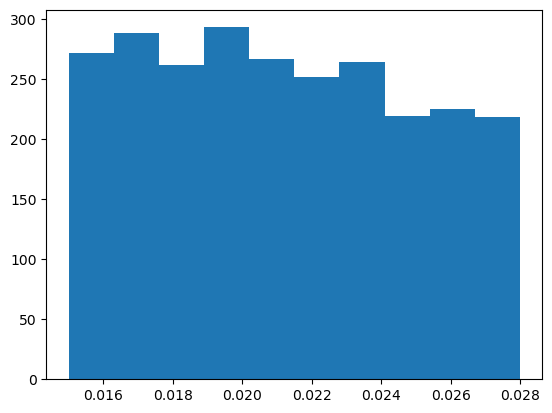

In [39]:
check_param_dist(var = "fates_fire_bark_scaler",index = 4)